# Bibliotecas

In [1]:
from obterDados import obterSimboloPosicao, obterSimboloData
from pickle import dump, load
import numpy as np
from tqdm import tqdm

# Abrindo dados

In [2]:
x = np.float64(np.load(open('data/x.npy', 'rb')))
y = np.int8(np.load(open('data/y.npy', 'rb')))

# Criar Modelos

### Lazy Classifier

In [3]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# lazyReg = LazyClassifier()
# x = np.load(open('data/x.npy', 'rb'))
# y = np.load(open('data/y.npy', 'rb'))
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
# results, models = lazyReg.fit(x_train, x_test, y_train, y_test)
# results

### XGBoost

In [5]:
from xgboost import XGBClassifier

modelo = XGBClassifier(objective="multi:softprob")
modelo.fit(x, y)
dump(modelo, open(f'models/modeloClassificadorXGBoost{str(x.shape[1])}.pickle', 'wb'))

### Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

modelo = ExtraTreesClassifier()
modelo.fit(x, y)
dump(modelo, open(f'models/modeloClassificadorExtraTrees{str(x.shape[1])}.pickle', 'wb'))

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

modelo = KNeighborsClassifier()
modelo.fit(x, y)
dump(modelo, open(f'models/modeloClassificadorKNN{str(x.shape[1])}.pickle', 'wb'))

### SVC

In [4]:
from sklearn.svm import SVC

modelo = SVC()
modelo.fit(x, y)
dump(modelo, open(f'models/modeloClassificadorSVC{str(x.shape[1])}.pickle', 'wb'))

### NuSVC

In [5]:
from sklearn.svm import NuSVC

modelo = NuSVC()
modelo.fit(x, y)

dump(modelo, open(f'models/modeloClassificadorNuSVC{str(x.shape[1])}.pickle', 'wb'))

# Avaliação dos modelos

In [15]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

modelo = load(open(f'models/modeloClassificadorNuSVC3006.pickle', 'rb'))

In [16]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2)

In [17]:
print(classification_report(y, modelo.predict(x)))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     20279
           1       0.87      0.89      0.88     20279
           2       0.87      0.90      0.88     20279

    accuracy                           0.87     60837
   macro avg       0.87      0.87      0.87     60837
weighted avg       0.87      0.87      0.87     60837



In [18]:
# print(classification_report(y_train, modelo.predict(x_train)))

In [19]:
# print(classification_report(y_test, modelo.predict(x_test)))

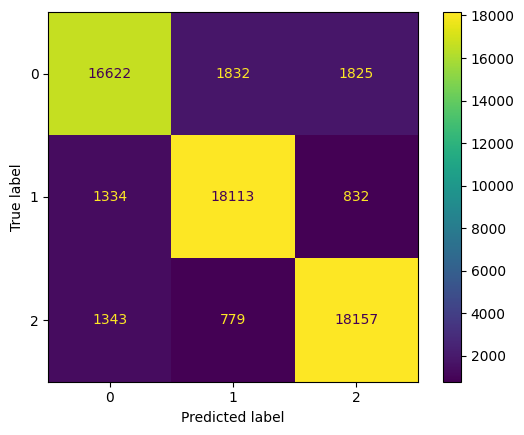

In [20]:
# ConfusionMatrixDisplay.from_estimator(modelo, x, y)

In [21]:
# ConfusionMatrixDisplay.from_estimator(modelo, x_train, y_train)

In [22]:
# ConfusionMatrixDisplay.from_estimator(modelo, x_test, y_test)

# Teste Finaceiro

In [23]:
from json import dumps

target = 30
stop = 10
timeLimit = 24
total = 0
long = False
short = False
position = 0
candle = -1
operacoes = {
    'longSuccess' : [0, 0],
    'longFail' : [0, 0],
    'longEndSuccess' : [0, 0],
    'longEndFail' : [0, 0],
    'shortSuccess' : [0, 0],
    'shortFail' : [0, 0],
    'shortEndSuccess' : [0, 0],
    'shortEndFail' : [0, 0],
}
for i in tqdm(range(50*108, -1, -1)):
    histM5 = obterSimboloPosicao('WDO$N', n=300, delayCandles=i)
    histM5['minute'] = histM5.index.minute
    histM5['hour'] = histM5.index.hour
    histM5['day_of_week'] = histM5.index.day_of_week
    histM5['day'] = histM5.index.day
    histM5NP = histM5.to_numpy()
    hist = np.zeros((501, 6))
    hist[0, -4:] = histM5NP[-1][-4:]
    hist[1:301] = histM5NP[:, :6]
    histD1 = obterSimboloData(histM5.index[-1])
    histD1NP = histD1.to_numpy()
    hist[301:] = histD1NP
    vmax = hist[1:301, :4].max()
    vmin = hist[1:301, :4].min()
    hist[1:301, :4] = (hist[1:301, :4] - vmin) / (vmax - vmin)
    vmax = hist[1:301, 4].max()
    vmin = hist[1:301, 4].min()
    hist[1:301, 4] = (hist[1:301, 4] - vmin) / (vmax - vmin)
    vmax = hist[1:301, 5].max()
    vmin = hist[1:301, 5].min()
    hist[1:301, 5] = (hist[1:301, 5] - vmin) / (vmax - vmin)
    vmax = hist[301:, :4].max()
    vmin = hist[301:, :4].min()
    hist[301:, :4] = (hist[301:, :4] - vmin) / (vmax - vmin)
    vmax = hist[301:, 4].max()
    vmin = hist[301:, 4].min()
    hist[301:, 4] = (hist[301:, 4] - vmin) / (vmax - vmin)
    vmax = hist[301:, 5].max()
    vmin = hist[301:, 5].min()
    hist[301:, 5] = (hist[301:, 5] - vmin) / (vmax - vmin)
    hist[0, 2] /= 60
    hist[0, 3] /= 24
    hist[0, 4] /= 4
    hist[0, 5] /= 31
    priceNow = histM5['close'].iloc[-1]
    if long:
        if priceNow >= position + target:
            total += priceNow - position
            long = False
            operacoes['longSuccess'][0] += 1
            operacoes['longSuccess'][1] += priceNow - position
        if priceNow <= position - stop:
            total += priceNow - position
            long = False
            operacoes['longFail'][0] += 1
            operacoes['longFail'][1] += priceNow - position
        if i >= candle + timeLimit:
            total += priceNow - position
            long = False
            if priceNow - position > 0:
                operacoes['longEndSuccess'][0] += 1
                operacoes['longEndSuccess'][1] += priceNow - position
            else:
                operacoes['longEndFail'][0] += 1
                operacoes['longEndFail'][1] += priceNow - position
        continue
    if short:
        if priceNow <= position - target:
            total += position - priceNow
            short = False
            operacoes['shortSuccess'][0] += 1
            operacoes['shortSuccess'][1] += position - priceNow
        if priceNow >= position + stop:
            total += position - priceNow
            short = False
            operacoes['shortFail'][0] += 1
            operacoes['shortFail'][1] += position - priceNow
        if i >= candle + timeLimit:
            total += position - priceNow
            short = False
            if position - priceNow > 0:
                operacoes['shortEndSuccess'][0] += 1
                operacoes['shortEndSuccess'][1] += position - priceNow
            else:
                operacoes['shortEndFail'][0] += 1
                operacoes['shortEndFail'][1] += position - priceNow
        continue

    previsao = modelo.predict([hist.flatten()])[0]
    if previsao == 1:
        long = True
        position = priceNow
        candle = i
        # print('Compra:', str(histM5.index[-1]))
    if previsao == 2:
        short = True
        position = priceNow
        candle = i
        # print('Venda:', str(histM5.index[-1]))

print('Total:', total)
print('Operações: ', dumps(operacoes, indent=4))

  0%|          | 0/5401 [00:00<?, ?it/s]

100%|██████████| 5401/5401 [15:22<00:00,  5.85it/s]

Total: 53.5
Operações:  {
    "longSuccess": [
        4,
        141.0
    ],
    "longFail": [
        12,
        -169.5
    ],
    "longEndSuccess": [
        0,
        0
    ],
    "longEndFail": [
        0,
        0
    ],
    "shortSuccess": [
        9,
        316.0
    ],
    "shortFail": [
        21,
        -234.0
    ],
    "shortEndSuccess": [
        0,
        0
    ],
    "shortEndFail": [
        0,
        0
    ]
}
